In [40]:
# Multinomial Naive Bayes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk
import re
import pickle
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [41]:
categories = ['-', 'o', '+']
#train = fetch_20newsgroups(subset='train', categories=categories)
#test = fetch_20newsgroups(subset='test', categories=categories)

In [42]:
# read data from csv
data = pd.read_csv("protocols/labelled/only_lockdown.csv", sep='\t', header=None, skiprows=[0])
data["opinion_integer"] = 0
data.loc[data[6] == '-', "opinion_integer"] = 0
data.loc[data[6] == 'o', "opinion_integer"] = 1
data.loc[data[6] == '+', "opinion_integer"] = 2

nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    words_tokens_lower = [word for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]
    return ' '.join(words_filtered)

# Clean Comments
data["comment_clean"] = data.loc[data[13].str.len() > 20, 13]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Downloading package punkt to /home/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,Das heißt diese Planbarkeit ist jetzt gar nich...,0
1,Wie und wann schaffen wir es aus diesem Lockdo...,0


In [43]:
def split_df(df, split_number):
    return df[:split_number], df[split_number:]

def corpus_split(holdback_per_class):
    train = pd.DataFrame()
    test = pd.DataFrame()

    for i in range(3):
        rows_with_class = data[data['label'] == i]
        rows_with_class = rows_with_class.sample(frac=1).reset_index(drop=True)
        l, r = split_df(rows_with_class, holdback_per_class)
        train = train.append(r, ignore_index=True)
        test = test.append(l, ignore_index=True)

    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)

    train_x = train['text'].tolist()
    test_x = test['text'].tolist()
    train_y = train['label'].tolist()
    test_y = test['label'].tolist()

    return train_x, test_x, train_y, test_y

In [44]:
runs = 1000
accs = []
for i in range(runs):
    train_data, test_data, train_label, test_label = corpus_split(20)
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    train_counts = Counter(train_label)
    num_in_largest_class = max(train_counts.values())
    class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}
    sample_weights = [class_weights[label] for label in train_label]
    model.fit(train_data, train_label, multinomialnb__sample_weight=sample_weights)
    labels = model.predict(test_data)
    correct = labels == test_label
    acc = np.array(correct).sum() / len(correct)
    accs.append(acc)
print(f"Mean Accuracy: {acc}")

Mean Accuracy: 0.4666666666666667


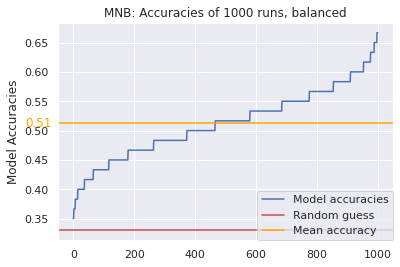

In [45]:
total = len(accs)
mean = sum(accs)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accs), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center",
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"MNB: Accuracies of {total} runs, balanced")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig('plots/accuracies_mnb_even_class.png')
plt.show()

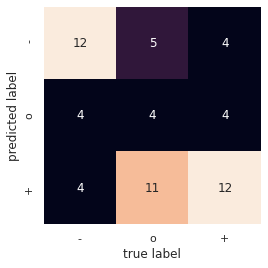

In [46]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

